# CPD GMM Registration Playground

## 1. See Reg Result 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Mean of sigma2:   sklearn 2.8344194222829783e-06    |    pycpd 1.8619778512035805e-06


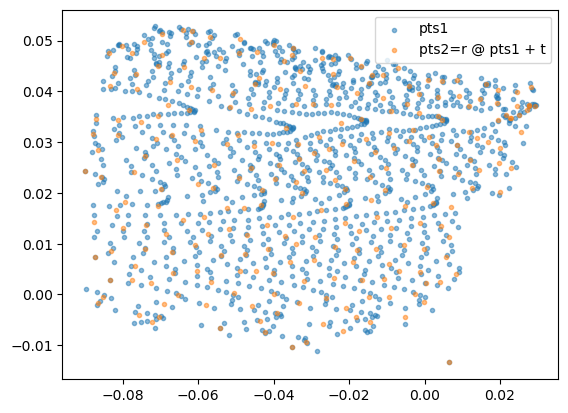

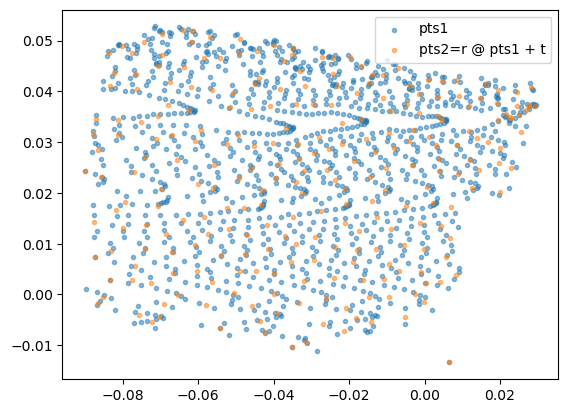

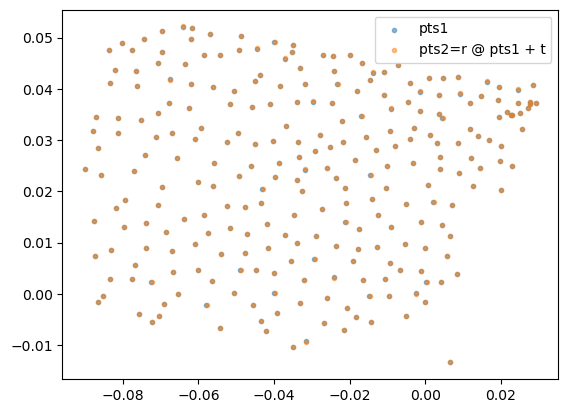

In [1]:
%load_ext autoreload 
%autoreload 2
import numpy as np, pickle
from os.path import expanduser
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
from pycpd.deformable_registration import DeformableRegistration
# from pycpd.pycpd.deformable_registration import DeformableRegistration


''' TODO: 
- [] Compare sklearn GMM variance vs. pyCPD updated variance.
     They should be the same (using the same tissue surface)
- [] Does the original scalar-valued sigma2 cause non-invertible matrices?
'''
from pycpd.utility import gaussian_corruption, plt_gmm, plt_gmm_o3d, wkmeans, gmm_params, \
    farthest_point_sample, pcd2depth, compare_pcd, compare_pcd_2d, pcd_to_o3d

pcd = np.load('/home/kyle/Desktop/data/pcd_toys/dense_surfel.npy')[::100]
# pcd = pickle.load(open(expanduser("~/Desktop/data/pcd_toys/teapot.pickle"), 'rb'))

def get_sklearn_gmm_params(pcd, num_clusters=256):
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='spherical')
    gmm.fit(pcd)
    mu = gmm.means_; sig = gmm.covariances_
    return mu, sig

''' Compute sklearn gmm params'''
mu, sig = get_sklearn_gmm_params(pcd)
reg_solver = DeformableRegistration(X=pcd, Y=mu, 
            max_iterations=50, sigma2=(sig)) # TODO:  X = target, Y = source
reg_solver.register()

mu_ = reg_solver.transform_point_cloud(mu)
sig_ = reg_solver.sigma2

# for _ in tqdm(range(100)): 
#     reg_solver = DeformableRegistration(X=pcd, Y=mu_, 
#             max_iterations=50, sigma2=(sig_)) # TODO:  X = target, Y = source
#     reg_solver.register()
#     mu_ = reg_solver.transform_point_cloud(mu_)
#     sig_ = reg_solver.sigma2


print(f'Mean of sigma2:   sklearn {np.mean(sig)}    |    pycpd {np.mean(sig_)}')
compare_pcd_2d([pcd, mu] )
compare_pcd_2d([pcd, mu_])
compare_pcd_2d([mu, mu_] )


## Developt Torch-based Optimization

In [17]:
%load_ext autoreload 
%autoreload 2
from pycpd.deformable_registration_torch import *
from pycpd.utility import *
from sklearn.mixture import GaussianMixture

def get_sklearn_gmm_params(pcd, num_clusters=256):
    gmm = GaussianMixture(n_components=num_clusters, covariance_type='spherical')
    gmm.fit(pcd)
    mu = gmm.means_; sig = gmm.covariances_
    return mu, sig

pcd = np.load('/home/kyle/Desktop/data/pcd_toys/dense_surfel.npy')
pcd = pcd[::100]
mu, sig = get_sklearn_gmm_params(pcd)

mu = numpy_to_torch(mu); sig = numpy_to_torch(sig)
pcd = numpy_to_torch(pcd)

X, Y = pcd, mu

reg_solver = DeformableRegistrationTorch(X=X, Y=Y, 
            max_iterations=50, sigma2=(sig)) # TODO:  X = target, Y = source
reg_solver.register()

mu_ = reg_solver.transform_point_cloud(mu)
sig_ = reg_solver.sigma2

# sigma2 = compute_sigma2(X,Y)


# print(f'Mean of sigma2:   sklearn {np.mean(sig)}    |    pycpd {np.mean(sig_)}')
compare_pcd_2d([mu, mu_, pcd])



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Teapot

In [ ]:
import pickle, numpy as np
from os.path import expanduser

from utils.utils import *
from utils.gmm_reg import *

pcd = pickle.load(open(expanduser("~/Desktop/data/pcd_toys/teapot.pickle"), 'rb'))
T = get_rand_transform(); r, t = T[:3,:3], T[:3,:3]
tgt, src = pcd, gaussian_corruption(pcd,std=0.1) @ r + t
tgt, src = numpy_to_torch(tgt).unsqueeze(0), numpy_to_torch(src).unsqueeze(0)

gamma, pi, mu = wkmeans(tgt)
pi, mu, sig = gmm_params(gamma, tgt, return_sigma=True)

gamma_, pi_, mu_ = wkmeans(src)
pi_, mu_, sig_ = gmm_params(gamma_, src, return_sigma=True)

T_pred = gmm_register(pi_, mu_, mu, sig).squeeze(0)
r_pred, t_pred = T_pred[:3,:3], T_pred[3,:3]

r_pred, t_pred, tgt, src = torch_to_numpy(r_pred), torch_to_numpy(t_pred), torch_to_numpy(tgt.squeeze(0)), torch_to_numpy(src.squeeze(0))

compare_pcd([tgt, src@r_pred+t_pred], title="Original vs. Reconstructed PCD")
compare_pcd([tgt, (src-t)@np.linalg.inv(r)])
